# Modelisation de clustering

Ce notebook renferme les essais des différentes approches de modélisation pour segmenter nos données.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

## Méthodes du projet

In [2]:
def plot_univarie(df, list_col, cust_bin=20):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=cust_bin)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

In [3]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df, silent=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64', 'int32'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64[ns]':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    if not silent:
        print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if not silent:
            print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [4]:
# pour tracer les boxplot des différentes variables RFM en fonction du cluster
def display_box_plot_comparison(df_w_cluster, col_to_display):
    cluster_unique = sorted(df_w_cluster["cluster"].unique())
    X_quali = "cluster" # qualitative

    for col in col_to_display:
        Y_quanti = col # quantitative

        groupes = []
        for m in cluster_unique:
            groupes.append(df_w_cluster[df_w_cluster[X_quali]==m][Y_quanti])

        # Propriétés graphiques    
        medianprops = {'color':"black"}
        meanprops = {'marker':'o', 'markeredgecolor':'black',
                    'markerfacecolor':'firebrick'}
        plt.figure(figsize=(12,6))
        res = plt.boxplot(
            groupes, labels=cluster_unique, showfliers=False, medianprops=medianprops,
            vert=True, patch_artist=False, showmeans=True, meanprops=meanprops)
        plt.xlabel("Clusters")
        plt.ylabel("{} value".format(col))

        # pour tracer les lignes des limites pour discuter sur le graphique
        min_xlim, max_xlim = plt.xlim()
        boxes_lim = [item.get_ydata() for item in res['boxes']]
        for m in cluster_unique:
            temp_low = round(boxes_lim[m][1], 1)
            temp_up = round(boxes_lim[m][2], 1)
            plt.axhline(temp_low, color='k', linestyle='dashed', linewidth=1)
            plt.text(max_xlim*0.91, temp_low, '{}'.format(temp_low))
            plt.axhline(temp_up, color='k', linestyle='dashed', linewidth=1)
            plt.text(max_xlim*0.91, temp_up, '{}'.format(temp_up))

        plt.show()

In [5]:
import psutil, sys
def check_ressource_usage():
    user = 'slerendu'
    # vals_cpu = np.mean([p.cpu_percent() for p in psutil.process_iter() if p.username() == user])
    vals_ram = sum([p.memory_percent() for p in psutil.process_iter() if p.username() == user])
    # print("CPU :", round(vals_cpu, 1), "%")
    print("RAM :", round(vals_ram, 1), "%")
    if vals_ram > 90:
        sys.exit()

In [6]:
def compute_dbscan(X_norm, ref_labels, silent=True):
    start = time.time()
    result_dbscan = []
    min_sample_range = range(5, 25, 5)
    epsilon_range = np.arange(0.1, 0.9, 0.10)
    nb_tot_combin = len(min_sample_range) * len(epsilon_range)
    nb_current_combi = 0
    for i in min_sample_range:
        for j in epsilon_range:
            nb_current_combi += 1
            dbscan = cluster.DBSCAN(eps=j,  min_samples=i)
            dbscan.fit(X_norm)
            check_ressource_usage()
            labels = dbscan.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            ari_dbscan = round(adjusted_rand_score(ref_labels, labels), 4)
            if not silent:
                print("-"*70)
                print("Epsilon :", round(j, 1), "- MinSample :", i)
                print("Clusters :", n_clusters_, "- Noise points :", n_noise_)
                print("ARI-Score :", ari_dbscan)
            perc_curr = (nb_current_combi/nb_tot_combin)*100
            perc_remain = ((nb_tot_combin - nb_current_combi)/nb_tot_combin)*100
            print("-"*int(perc_curr) + " "*int(perc_remain) + str(round(perc_curr, 1)) + "%")
            result_dbscan.append([round(j, 1), i, n_clusters_, n_noise_, ari_dbscan])
    
    end = time.time()
    delta = round(end - start, 0)
    print("DBSCAN combinaisons parcourues en:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    return pd.DataFrame(result_dbscan, columns=['eps', 'minsample', 'cluster', 'noise', 'ari'])

In [7]:
def display_bilan_clusters_rfm(df):
    agg = {
        'rfm_recency': 'mean',
        'rfm_frequency': 'mean',
        'rfm_monetary': 'mean',
        'cluster': 'count'
    }
    # on regroupe par customer_unique_id pour appliquer les aggrégations
    clustering_table = df.groupby(["cluster"]).agg(agg)
    # on renomme les colonnes pour l'étude des modèles
    clustering_table.rename(
        columns={'rfm_recency': 'recency_mean',
                 'rfm_frequency': 'frequency_mean',
                 'rfm_monetary': 'monetary_mean',
                 'cluster': 'cluster_size'}, inplace=True)
    clustering_table["cluster_perc"] = round(clustering_table["cluster_size"] / len(df) * 100, 1)
    display(clustering_table.head())
    return clustering_table

In [8]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### YellowBrick

In [9]:
from yellowbrick.cluster import KElbowVisualizer
def define_cluster_numbers(X_norm, metric='distortion', nb_clusters=(2, 11)):
    start = time.time()
    
    clust = cluster.KMeans()
    visualizer = KElbowVisualizer(clust, metric=metric, k=nb_clusters)
    visualizer.fit(X_norm)
    visualizer.poof()
    
    end = time.time()
    delta = round(end - start, 0)
    print("Clusters définis en:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")
    print("D'après cette analyse, le nombre de cluster optimal est de", visualizer.elbow_value_)
    return visualizer.elbow_value_

In [10]:
from yellowbrick.cluster import SilhouetteVisualizer
def display_silhouette_clusters(X_norm, nb_clusters=[]):
    start = time.time()
    if len(nb_clusters) == 0:
        print("La liste de nombre de clusters n'est pas renseignée.")
    else:
        for n_cluster in nb_clusters:
            print("Visualisation avec", n_cluster, "clusters en cours...")
            kmeans = cluster.KMeans(n_clusters=n_cluster)
            visualizer = SilhouetteVisualizer(kmeans)
            visualizer.fit(X_norm)
            visualizer.poof()
    
            end = time.time()
            delta = round(end - start, 0)
            start = time.time()
            print("Visualisation de Silhouette sur", n_cluster, " clusters fait en :", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")    

## Chargement des données

On commence par charger le dataset d'étude préparé dans le notebook d'analyse exploratoire.

In [11]:
parse_date_col = [
    "review_creation_date",
    "review_answer_timestamp",
    "shipping_limit_date",
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']
data = pd.read_csv("study_dataset.csv", encoding='utf-8', sep='\t', index_col=0, parse_dates=parse_date_col)

In [12]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,124.99,21.88,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,112.99,24.90,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,124.99,15.62,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,106.99,30.59,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,88460,angelina,SC,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-03-23 15:25:11,2017-03-28 18:23:51,...,126.99,15.06,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0


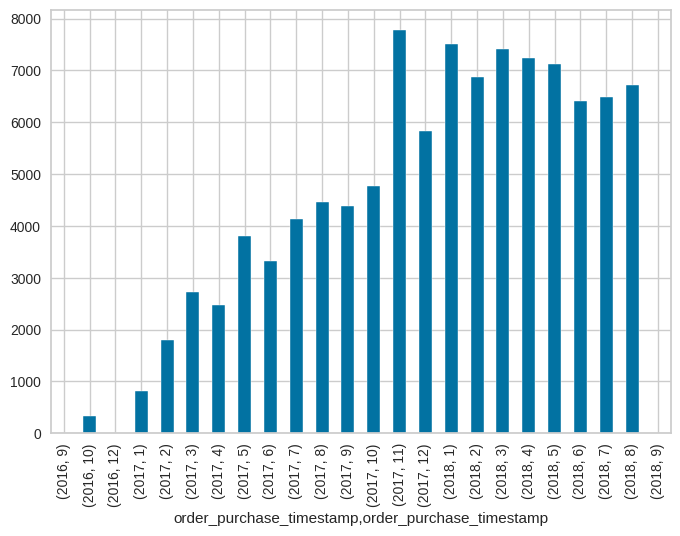

In [13]:
data["order_purchase_timestamp"].groupby([data["order_purchase_timestamp"].dt.year, data["order_purchase_timestamp"].dt.month]).count().plot(kind="bar")
plt.show()

Il est important de se poser la question sur la pertinence des données. Si on veut des données conséquentes, il faudrait une période de 1 an durant laquelle il y a un maximum de données. On peut le voir sur la période entre 09/2017 jusqu'à 08/2018.  
Cependant, le graphique précédent nous montre surtout le début de l'entreprise qui a été fondée en février 2015. Il y a donc 2 approches possibles : 
 - toutes les données : pour nous montrer l'évolution des clients et des performances
 - la dernière année pertinente : pour étudier la performance de l'entreprise à un instant donné

In [14]:
# Possible étude avec les données entre 09/2017 et 08/2018
# data = data.loc[(data["order_purchase_timestamp"] >= '2017-09-01 00:00:00') & (data["order_purchase_timestamp"] <= '2018-08-31 23:59:59'), :]
old_data = data.loc[data["order_purchase_timestamp"] < '2017-09-01 00:00:00', :]
print("Les données des débuts de l'entreprise représentent", old_data.shape[0], "lignes, soit", str(round(old_data.shape[0]/data.shape[0]*100, 1)), "% du total.")

Les données des débuts de l'entreprise représentent 23877 lignes, soit 23.3 % du total.


# Création des variables RFM

Maintenant, on va créer les composantes de l'étude RFM : 
 - Recency : le nombre de jour depuis le dernier achat
 - Frequency : le nombre d'achat fait durant toute la période du dataset
 - Monetary : le montant total dépensé durant toute la période du dataset

In [15]:
# on passe la colonne de date d'achat de timestamp à datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [16]:
# on récupère la dernière date du dataset pour la comparaison
last_purchase_date = data["order_purchase_timestamp"].max() + timedelta(days=1)
print("La dernière date de référence que nous prendrons est :", last_purchase_date)

La dernière date de référence que nous prendrons est : 2018-09-04 09:06:57


In [17]:
# on calcule le montant acheté par ligne
# nb d'article * (prix de l'article + frais de port de l'article)
data['order_value_by_item'] = data['order_item_id'] * (data['price'] + data["freight_value"])

In [18]:
# aggregation nécessaires pour les calculs RFM
aggregation = {
    'order_purchase_timestamp': lambda x: (last_purchase_date - x.max()).days,
    'order_id': 'count',
    'order_value_by_item': 'sum'
}

In [19]:
# on regroupe par customer_unique_id pour appliquer les aggrégations
data_process = data.groupby(['customer_unique_id']).agg(aggregation)
# on renomme les colonnes pour l'étude des modèles
data_process.rename(
    columns={'order_purchase_timestamp': 'rfm_recency',
             'order_id': 'rfm_frequency',
             'order_value_by_item': 'rfm_monetary'}, inplace=True)

In [20]:
data_process.head()

,rfm_recency,rfm_frequency,rfm_monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [21]:
data_process.describe()

,rfm_recency,rfm_frequency,rfm_monetary
count,95420.000000,95420.000000,95420.000000
mean,243.600377,1.073412,171.379334
std,153.160320,0.328689,242.628168
min,1.000000,1.000000,9.590000
25%,119.000000,1.000000,63.220000
50%,224.000000,1.000000,108.810000
75%,353.000000,1.000000,186.882500
max,729.000000,16.000000,13664.080000


On remarque que au moins 75% des clients ont acheté une seule fois.

In [22]:
nb_more_than_one = len(data_process.loc[data_process["rfm_frequency"] > 1, :])
print("On dénombre", nb_more_than_one, "clients fidèles, càd ayant acheté plus d'une fois, soit", str(round(nb_more_than_one/len(data_process)*100, 1)), "% du total.")

On dénombre 5789 clients fidèles, càd ayant acheté plus d'une fois, soit 6.1 % du total.


----------------------------------------------------------------------
Colonne : rfm_recency
moyenne :  243.60037727939635
médiane :  224.0
mode :  0    283
Name: rfm_recency, dtype: int64
min :  1
max :  729
quartiles :  [119.0, 353.0]
variance :  23457.837681685367
écart-type :  153.15951711103483
coefficient de variation :  0.6287326761213067
skewness :  0.4487102083883536
kurtosis :  -0.654949265709651


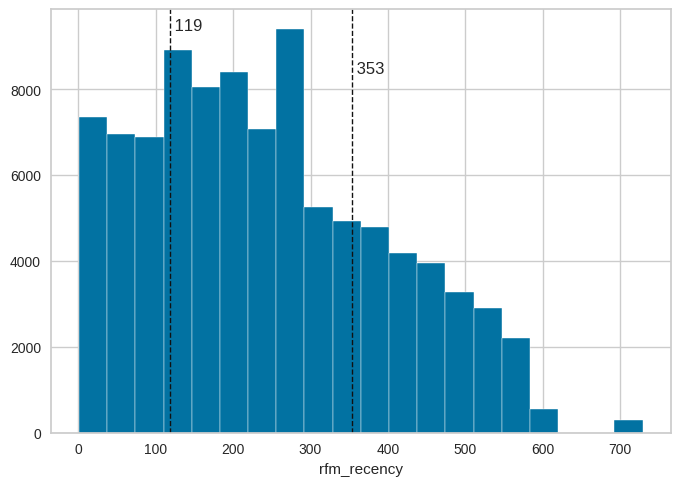

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : rfm_frequency
moyenne :  1.073412282540348
médiane :  1.0
mode :  0    1
Name: rfm_frequency, dtype: int64
min :  1
max :  16
quartiles :  [1.0, 1.0]
variance :  0.1080354952924425
écart-type :  0.32868753443421383
coefficient de variation :  0.30620809895740964
skewness :  7.481290460044968
kurtosis :  120.13637750563369


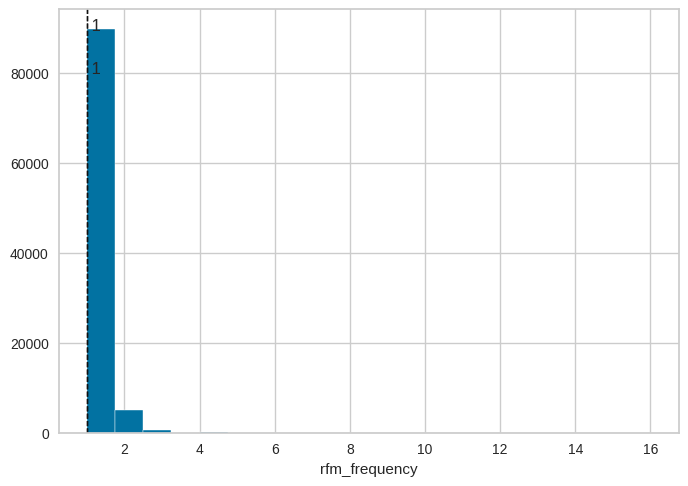

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : rfm_monetary
moyenne :  171.37933431146513
médiane :  108.81
mode :  0    77.57
Name: rfm_monetary, dtype: float64
min :  9.59
max :  13664.08
quartiles :  [63.22, 186.8825]
variance :  58867.81093680063
écart-type :  242.62689656507712
coefficient de variation :  1.4157301843880812
skewness :  8.844982958127842
kurtosis :  199.1436983446185


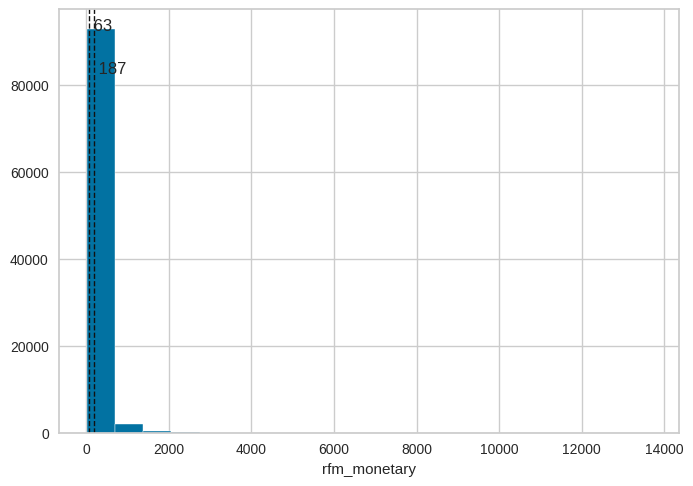

----------------------------------------------------------------------


In [23]:
plot_univarie(data_process, data_process.columns)

# Clustering

In [24]:
from sklearn import cluster
from sklearn import preprocessing

In [25]:
# on prépare les données en les normalisant
X = data_process.values
# X_norm = preprocessing.scale(X)
scaler = preprocessing.RobustScaler()
X_norm = scaler.fit_transform(X)

## KMeans

### Recherche du nombre de clusters optimal

A l'aide du KMeans, on évalue le nombre de cluster optimal.

In [26]:
# optimal_k = define_cluster_numbers(X_norm)

Et on visualise le diagramme de silouhettes.

In [27]:
# display_silhouette_clusters(X_norm, nb_clusters=[optimal_k])

In [28]:
sns.reset_orig()

### Etude des clusters

Regardons d'abord avec la valeur optimale calculée pour 4 clusters.

In [29]:
# on relance le KMeans avec le nb de cluster optimal
kmeans = cluster.KMeans(n_clusters=4)
kmeans.fit(X_norm)
# puis on récupère le libellé du cluster pour chaque client
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = data_process.index.values
cluster_map['cluster'] = kmeans.labels_
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(data_process, cluster_map, on="customer_unique_id", how="inner")

In [30]:
display_bilan_clusters_rfm(data_w_cluster)

,recency_mean,frequency_mean,monetary_mean,cluster_size,cluster_perc
cluster,,,,,
0,243.588034,1.030446,99.979589,78106,81.9
1,246.592000,1.347810,970.758899,2625,2.8
2,237.619178,1.457534,2534.617836,365,0.4
3,243.271851,1.247626,353.995577,14324,15.0


L'un des clusters représente moins de 1% des données. Nous allons donc passer à 3 clusters pour voir si la représentation est plus pertinente.

In [31]:
# on relance le KMeans avec le nb de cluster optimal
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X_norm)
# puis on récupère le libellé du cluster pour chaque client
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = data_process.index.values
cluster_map['cluster'] = kmeans.labels_
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(data_process, cluster_map, on="customer_unique_id", how="inner")

In [32]:
display_bilan_clusters_rfm(data_w_cluster)

,recency_mean,frequency_mean,monetary_mean,cluster_size,cluster_perc
cluster,,,,,
0,243.656062,1.044030,114.396137,85373,89.5
1,242.777924,1.314041,534.089085,9123,9.6
2,246.575758,1.412338,1855.173117,924,1.0


Un cluster est certes peu représenté, mais il dénombre les clients ayant dépensé le plus et étant plus fidèles, càd ayant acheté au moins 2 fois en moyenne. Nous allons donc concerver cette configuration pour le KMeans.  
Regardons la représentation des ces répartitions avec des boxplots.

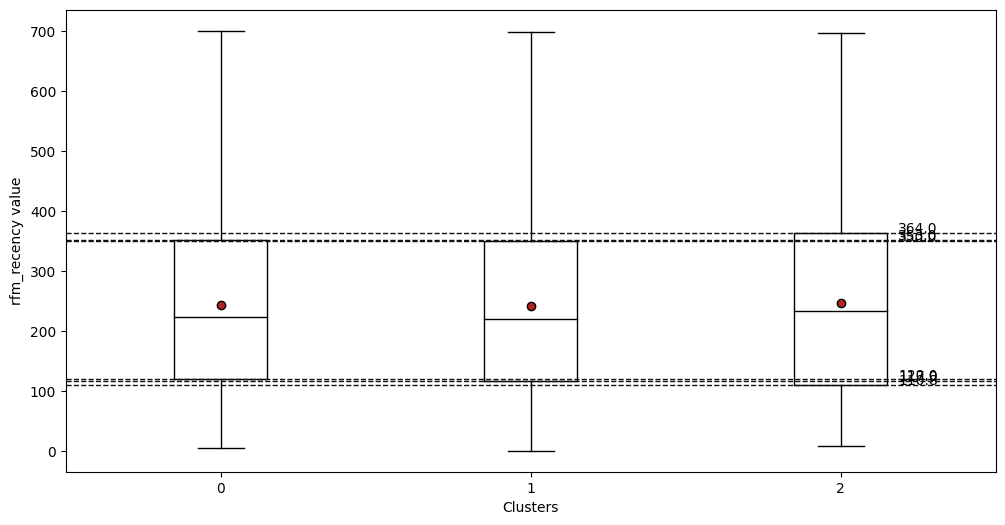

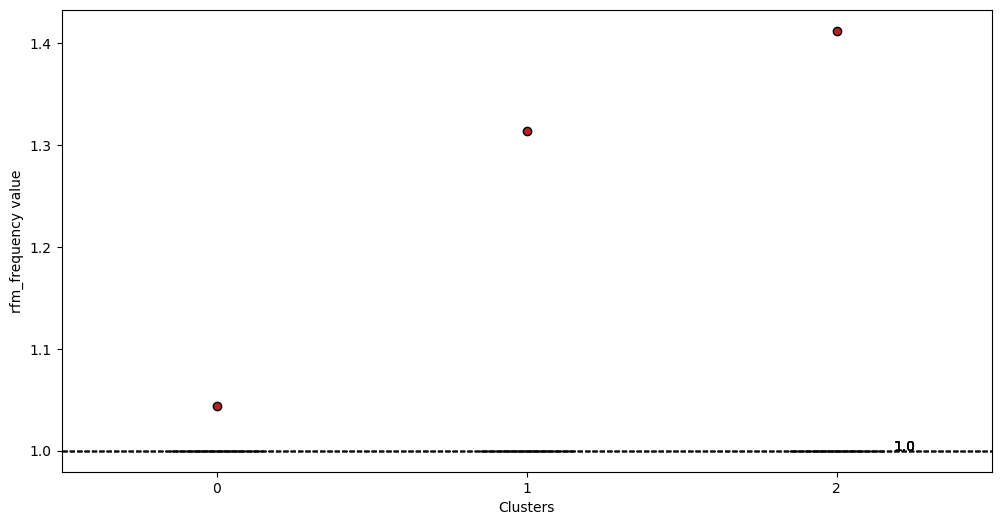

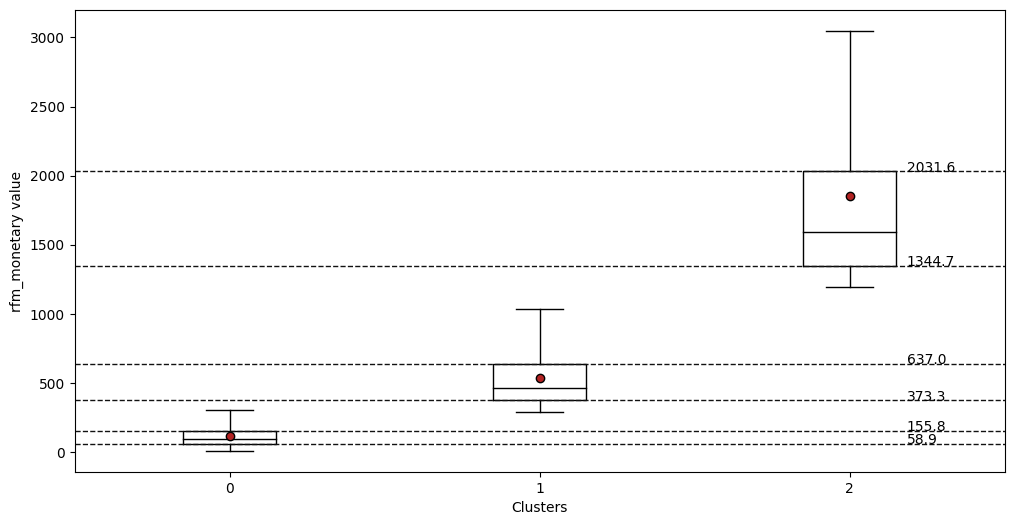

In [33]:
display_box_plot_comparison(data_w_cluster, data_process.columns)

On observe bien les 3 groupes : 
 - bons acheteurs (entre 1340 et 2040 real), fidèles (1.4 fois)
 - acheteurs moyens (entre 370 et 640 real), réguliers (1.3 fois)
 - petits acheteurs (entre 60 et 160 real), occasionnels (1 fois)

A noter que tous les clusters ont une utilisation similaire au niveau du dernier achat.

In [34]:
# import plotly.express as px
# fig = px.scatter_3d(data_w_cluster, x='rfm_recency', y='rfm_frequency', z='rfm_monetary', opacity=0.3, color='cluster', width=800, height=600)
# fig.update_traces(marker_size = 3)
# fig.show()

## DBSCAN

### Recherche Epsilon et MinSample

In [35]:
from sklearn.metrics import adjusted_rand_score

In [36]:
# result = False
# result = compute_dbscan(X_norm, kmeans.labels_)

In [37]:
# best_result_dbscan = result.sort_values(by=["cluster", "noise"], ascending=[True, False]).reset_index(drop=True)
# # best_result_dbscan = result.loc[result["cluster"] == 3, :].sort_values(by="ari", ascending=False).reset_index(drop=True)
# display(best_result_dbscan.head())
# print("Meilleure combinaison : Epsilon", best_result_dbscan.iloc[0]["eps"], "- MinSample", int(best_result_dbscan.iloc[0]["minsample"]))

On voit que les valeurs de ARI-score sont très faible (autour de 0.2). Cela montre que les clusters sont très différents de ceux du KMeans.

### Etude des clusters

In [38]:
# on relance le DBSCAN avec le nb de cluster optimal
dbscan = cluster.DBSCAN(eps=0.5, min_samples=20)
# dbscan = cluster.DBSCAN(eps=best_result_dbscan.iloc[0]["eps"], min_samples=int(best_result_dbscan.iloc[0]["minsample"]))
dbscan.fit(X_norm)
# puis on récupère le libellé du cluster pour chaque client
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = data_process.index.values
cluster_map['cluster'] = dbscan.labels_

In [39]:
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(data_process, cluster_map, on="customer_unique_id", how="inner")

Estimated number of clusters: 3
Estimated number of noise points: 696


In [40]:
display_bilan_clusters_rfm(data_w_cluster)

,recency_mean,frequency_mean,monetary_mean,cluster_size,cluster_perc
cluster,,,,,
-1,268.556034,2.824713,1571.611408,696,0.7
0,244.060255,1.000000,153.771955,89453,93.7
1,234.176201,2.000000,279.167818,4807,5.0
2,215.142241,3.000000,348.819246,464,0.5


On voit que 2 clusters représentent moins de 1% des données. C'est donc similaire à si nousa vions que 2 clusters. Par ailleurs, plus de 90% des données sont localisées dans un seul cluster. Ce n'est pas assez intéressant pour faire une étude de cas.

## AgglomerativeClustering

### Recherche des clusters

In [41]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
# pour info : 65% des données utilisent 75% de ma RAM (37Go utilisé)
# pour des raisons techniques, nous allons utiliser un échantillon de 40% des données.
nb_data = len(data_process)
sample = np.random.randint(nb_data, size=int(nb_data*0.40))
agglo_data = data_process.iloc[sample]

In [43]:
X = agglo_data.values
# X_norm = preprocessing.scale(X)
scaler = preprocessing.RobustScaler()
X_norm = scaler.fit_transform(X)

In [44]:
model = AgglomerativeClustering(n_clusters=3, distance_threshold=None, compute_distances=True)
model = model.fit(X_norm)

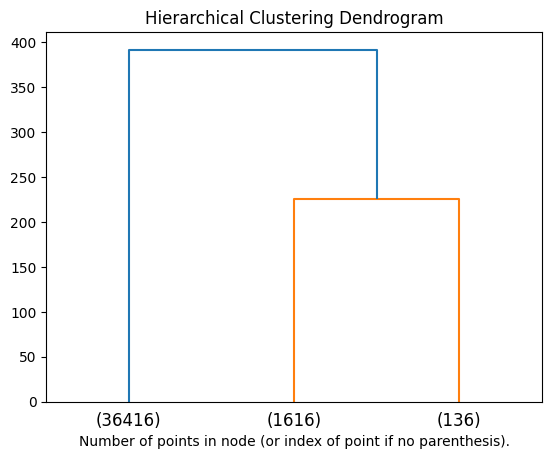

In [45]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top p levels of the dendrogram
plot_dendrogram(model, truncate_mode="lastp", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Etudes des clusters

In [46]:
# puis on récupère le libellé du cluster pour chaque client
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = agglo_data.index.values
cluster_map['cluster'] = model.labels_
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(agglo_data, cluster_map, on="customer_unique_id", how="inner")

In [47]:
display_bilan_clusters_rfm(data_w_cluster)

,recency_mean,frequency_mean,monetary_mean,cluster_size,cluster_perc
cluster,,,,,
0,244.271834,1.061191,134.133242,50792,95.4
1,222.465116,1.255814,2550.778605,172,0.3
2,212.715799,1.260812,835.017065,2266,4.3


On peut voir que la répartition est plus proche de celle apportée par le KMeans.

In [48]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X_norm)
ari_agglo_kmeans = round(adjusted_rand_score(kmeans.labels_, model.labels_), 4)
print("ARI-score entre KMeans et AgglomerativeClustering :", ari_agglo_kmeans)

ARI-score entre KMeans et AgglomerativeClustering : 0.5362


En effet, le ARI-score est supérieur à 0.50. Ce qui montre une certaine similarité et donc que une étude par AgglomerativeClustering n'apporte pas de valeurs ajoutées. Par ailleurs, seulement 40% des données n'est pas très représentatif de notre dataset. A partir de là, nous allons donc continuer avec l'algorithme du KMeans.

## Scénario avec KMeans

Nous allons maintenant voir l'intérêt du clustering par KMeans en calculant le gain obtenu selon différents scénario : 
 - nous allons déplacer 20% des petits acheteurs dans le cluster des bons acheteurs et comparer le CA
 - puis nous allons déplacer 20% des acheteurs moyens dans le cluster des bons acheteurs et comparer le CA

Nous allons donc d'abord calculer le CA global avec la configuration actuelle.

In [81]:
ca_global_ref = data_w_cluster["rfm_monetary"].sum()
print("Le CA global pour cette configuration est de", f'{round(ca_global_ref, 2):,}'.replace(',', ' '), "real.")

Le CA global pour cette configuration est de 16 353 016.08 real.


In [82]:
X = data_process.values
scaler = preprocessing.RobustScaler()
X_norm = scaler.fit_transform(X)

In [83]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X_norm)
cluster_map = pd.DataFrame()
cluster_map['customer_unique_id'] = data_process.index.values
cluster_map['cluster'] = kmeans.labels_
# on incorpore cette données au dataframe global
data_w_cluster = pd.merge(data_process, cluster_map, on="customer_unique_id", how="inner")

In [84]:
res = display_bilan_clusters_rfm(data_w_cluster)

,recency_mean,frequency_mean,monetary_mean,cluster_size,cluster_perc
cluster,,,,,
0,243.656496,1.043906,114.318329,85341,89.4
1,242.773323,1.314289,533.275206,9154,9.6
2,246.607568,1.411892,1854.458746,925,1.0


In [85]:
res = res.sort_values(by="monetary_mean").reset_index(drop=True)

In [86]:
# on récupère les index de cluster par type
idx_clust_little = res.index[0]
idx_clust_medium = res.index[1]

In [87]:
# test du scénario 1
data_for_scene_01 = data_w_cluster.copy()
change = data_for_scene_01.loc[data_w_cluster["cluster"] == idx_clust_little, :].sample(frac = 0.2).index
data_for_scene_01.loc[change,'rfm_monetary'] = res.iloc[2].monetary_mean
ca_global_ref_scene_01 = data_for_scene_01["rfm_monetary"].sum()
print("Le CA global pour cette configuration est de",
      f'{round(ca_global_ref_scene_01, 2):,}'.replace(',', ' '),
      "real, une augmentation de", round((ca_global_ref_scene_01-ca_global_ref)/ca_global_ref*100, 2), "%")

Le CA global pour cette configuration est de 46 043 045.94 real, une augmentation de 181.56 %


In [88]:
# test du scénario 2
data_for_scene_02 = data_w_cluster.copy()
change = data_for_scene_02.loc[data_w_cluster["cluster"] == idx_clust_medium, :].sample(frac = 0.2).index
data_for_scene_02.loc[change,'rfm_monetary'] = res.iloc[2].monetary_mean
ca_global_ref_scene_02 = data_for_scene_02["rfm_monetary"].sum()
print("Le CA global pour cette configuration est de",
      f'{round(ca_global_ref_scene_02, 2):,}'.replace(',', ' '),
      "real, une augmentation de", round((ca_global_ref_scene_02-ca_global_ref)/ca_global_ref*100, 2), "%")

Le CA global pour cette configuration est de 18 781 696.9 real, une augmentation de 14.85 %


# Ajouts de variables

## Création de variables pertinentes

In [89]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_value_by_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,252.25


## Utilisation du KMeans